# Plant Classification with Transfer Learning

## Learning Objectives
- Learn how to use transfer learning with pre-trained models
- Understand image preprocessing and data augmentation
- Build a plant classification model using Keras/TensorFlow
- Train and evaluate a deep learning model

## What We'll Do
1. Load and preprocess plant images
2. Use a pre-trained MobileNet model (trained on ImageNet)
3. Add our own classification layers for plant species
4. Train the model with data augmentation
5. Evaluate the model's performance

## Step 1: Import Libraries

We'll use TensorFlow/Keras for deep learning, and other libraries for image processing and visualization.
We'll also be importing xgboost as the modification to the improved baseline model. Machine learning demonstrating.

In [1]:
import tensorflow as tf
!pip install --upgrade xgboost
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict
import xgboost as xgb
from xgboost import XGBClassifier


print("TensorFlow version:", tf.__version__)

2025-12-09 19:51:50.624002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 19:51:50.640814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-09 19:51:50.660504: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-09 19:51:50.666949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-09 19:51:50.681243: I tensorflow/core/platform/cpu_feature_guar

Defaulting to user installation because normal site-packages is not writeable
TensorFlow version: 2.17.0


## Step 2: Set Up Data Paths and Parameters

Define where our training and test data are located, and set image size and batch size.

## Step 3: Load and Preprocess Data

We'll use Keras's ImageDataGenerator to load images from directories. 

**Important**: Since images come in different sizes, we need to resize them properly:
- We'll resize images maintaining their aspect ratio (no stretching!)
- The longest side will be resized to our target size
- We'll pad with white pixels to make images square
- This prevents distortion and preserves image quality

**Data Augmentation**: We'll apply random transformations to training images (flips, rotations, etc.) to help the model generalize better.


In [2]:
# Set up paths and parameters
IMG_SIZE = 224  # MobileNet works well with 224x224 images
BATCH_SIZE = 32
train_dir = "datasets/dataset"
test_dir = "datasets/dataset-test"

# Get the number of classes from the training directory
# Each subdirectory represents a different plant class
class_names = sorted([d for d in os.listdir(train_dir) 
                      if os.path.isdir(os.path.join(train_dir, d))])
num_classes = len(class_names)

print(f"Found {num_classes} plant classes")
print(f"Sample classes: {class_names[:5]}...")

Found 63 plant classes
Sample classes: ['.ipynb_checkpoints', 'Alfalfa', 'Asparagus', 'Blue Vervain', 'Broadleaf Plantain']...


In [29]:
# Remove the .ipynb thing from the beginning of the classes list
class_names = class_names[1:] 

In [3]:
from PIL import Image
import numpy as np
import glob

def load_and_preprocess_image(image_path, target_size=IMG_SIZE):
    """
    Load an image and preprocess it maintaining aspect ratio.
    This prevents stretching/distortion of images.
    
    Args:
        image_path: Path to the image file
        target_size: Target size for the longest side
    
    Returns:
        Processed image array (target_size x target_size) with aspect ratio preserved
    """
    # Load image
    img = Image.open(image_path).convert('RGB')
    
    # Get original dimensions
    orig_width, orig_height = img.size
    
    # Calculate new dimensions maintaining aspect ratio
    # Resize so longest side becomes target_size
    if orig_width > orig_height:
        new_width = target_size
        new_height = int(target_size * orig_height / orig_width)
    else:
        new_height = target_size
        new_width = int(target_size * orig_width / orig_height)
    
    # Resize image maintaining aspect ratio (using high-quality resampling)
    img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create white background canvas
    img_padded = Image.new('RGB', (target_size, target_size), color=(255, 255, 255))
    
    # Center the resized image on the canvas
    offset_x = (target_size - new_width) // 2
    offset_y = (target_size - new_height) // 2
    img_padded.paste(img_resized, (offset_x, offset_y))
    
    # Convert to numpy array and normalize to [0, 1]
    return np.array(img_padded, dtype=np.float32) / 255.0

# Create a custom generator that properly handles aspect ratio
def create_image_generator(directory, batch_size, shuffle=True, augment=False):
    """
    Create a generator that loads images maintaining aspect ratio.
    """
    # Get all image files
    image_paths = []
    labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # Find all image files
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            image_paths.extend(glob.glob(os.path.join(class_dir, ext)))
            labels.extend([class_idx] * len(glob.glob(os.path.join(class_dir, ext))))
    
    # Convert to numpy arrays
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    
    # Shuffle if needed
    if shuffle:
        indices = np.random.permutation(len(image_paths))
        image_paths = image_paths[indices]
        labels = labels[indices]
    
    # Create one-hot encoded labels
    labels_onehot = tf.keras.utils.to_categorical(labels, num_classes)
    
    # Generator function
    def generator():
        while True:
            for i in range(0, len(image_paths), batch_size):
                batch_paths = image_paths[i:i+batch_size]
                batch_labels = labels_onehot[i:i+batch_size]
                
                # Load and preprocess images
                batch_images = []
                for path in batch_paths:
                    img = load_and_preprocess_image(path)
                    
                    # Apply augmentation if training
                    if augment:
                        # Horizontal flip
                        if np.random.random() > 0.5:
                            img = np.fliplr(img)
                        # Random rotation (simple version)
                        if np.random.random() > 0.5:
                            angle = np.random.uniform(-20, 20)
                            # Convert to PIL for rotation, then back
                            img_pil = Image.fromarray((img * 255).astype(np.uint8))
                            img_pil = img_pil.rotate(angle, fillcolor=(255, 255, 255))
                            img = np.array(img_pil, dtype=np.float32) / 255.0
                    
                    batch_images.append(img)
                
                yield np.array(batch_images), batch_labels
    
    return generator(), len(image_paths)

# Create generators
train_gen, train_samples = create_image_generator(
    train_dir, BATCH_SIZE, shuffle=True, augment=True
)
test_gen, test_samples = create_image_generator(
    test_dir, BATCH_SIZE, shuffle=False, augment=False
)

print(f"\nTraining samples: {train_samples}")
print(f"Test samples: {test_samples}")
print(f"Number of classes: {num_classes}")
print(f"\n✓ Images are resized maintaining aspect ratio (no stretching!)")
print(f"  Longest side → {IMG_SIZE}px, padded to {IMG_SIZE}x{IMG_SIZE} square")



Training samples: 6554
Test samples: 310
Number of classes: 63

✓ Images are resized maintaining aspect ratio (no stretching!)
  Longest side → 224px, padded to 224x224 square


## Step 4: Build the Model with Transfer Learning

**Transfer Learning**: Instead of training from scratch, we'll use MobileNetV2, a model pre-trained on ImageNet (millions of images). We'll:
1. Use MobileNetV2 as a "feature extractor" (frozen weights)
2. Add our own classification layers on top for plant species (in this case regression with XGBoost)
3. Train only the new layers first, then fine-tune the whole model


### Building the Model


In [4]:
# Load the pre-trained MobileNetV2 model (without the top classification layer)
# include_top=False means we'll add our own classification layers
base_model = MobileNetV2(
    weights='imagenet',           # Use weights pre-trained on ImageNet
    include_top=False,            # Don't include the final classification layer
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model so we don't train it initially
# This allows us to train just our new layers first
base_model.trainable = False

# Add our own classification layers on top
# GlobalAveragePooling2D converts the feature maps to a single vector
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout helps prevent overfitting
cnn_predictions = Dense(num_classes, activation='softmax', name = 'cnn_output')(x)  # Final classification layer


# Create the complete model
model = Model(inputs=base_model.input, outputs=cnn_predictions)

# Compile the model
# categorical_crossentropy is used for multi-class classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model.summary()


2025-12-09 19:51:56.341520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13745 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:da:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

### Step 5: Prepare an extractor model to pull out usable values for XGBoost

A feature extractor layer will be needed to use XGBoost, placed before the final classification layer.

In [10]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Step 1: Collect all data from your generators
def collect_all_data(generator, num_samples):
    """Collect all images and labels from a generator"""
    all_images = []
    all_labels = []
    
    # Reset generator
    gen, _ = generator
    
    num_batches = (num_samples + BATCH_SIZE - 1) // BATCH_SIZE
    
    for i in range(num_batches):
        batch_images, batch_labels = next(gen)
        all_images.append(batch_images)
        all_labels.append(batch_labels)
    
    # Convert to numpy arrays
    X = np.vstack(all_images)  # Shape: (num_samples, 224, 224, 3)
    y = np.vstack(all_labels)  # Shape: (num_samples, num_classes)
    
    return X, y

print("Collecting training data...")
X_train_raw, Y_train = collect_all_data((train_gen, train_samples), train_samples)
print("Collecting test data...")
X_test_raw, Y_test = collect_all_data((test_gen, test_samples), test_samples)

# Convert labels from one-hot to integers
Y_train_int = np.argmax(Y_train, axis=1)
Y_test_int = np.argmax(Y_test, axis=1)

# Convert 1-indexed to 0-indexed if necessary
if Y_train_int.min() == 1:
    Y_train_int -= 1
    Y_test_int -= 1

print(f"Raw training images shape: {X_train_raw.shape}")
print(f"Training labels shape: {Y_train_int.shape}")

# Step 2: Extract features using your trained model
print("\nExtracting features with MobileNetV2...")

# Create feature extractor - get output from global average pooling layer
feature_extractor = Model(inputs=model.input, 
                         outputs=model.get_layer('global_average_pooling2d').output)

# Extract features
X_train_features = feature_extractor.predict(X_train_raw, verbose=1, batch_size=BATCH_SIZE)
X_test_features = feature_extractor.predict(X_test_raw, verbose=1, batch_size=BATCH_SIZE)

print(f"Extracted features shape: {X_train_features.shape}")  # Should be (6554, 1280)

# Validation split
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_features, Y_train_int, test_size=0.2, random_state=42
)

Raw training images shape: (6554, 224, 224, 3)
Training labels shape: (6554,)

Extracting features with MobileNetV2...
10/10 [==============================] - 0s 34ms/step
Extracted features shape: (6554, 1280)


## Step 5: Test the Model

We aren't classifying with the base model, the MobileNetV2, it's just being used to extract features for XGBoost to use.
So we'll train and test XGBoost and then use that instead. Feature extraction + classifier stacking.


In [18]:
print("\nTraining XGBoost...")
# Train the model
xgb_model = xgb.XGBClassifier(
    tree_method='hist',           # Fast histogram-based
    n_jobs=-1,                    # All CPU cores
    n_estimators=150,             # Fewer trees for speed
    max_depth=6,                  # Shallower for speed
    learning_rate=0.1,            # Faster learning
    colsample_bytree=0.7,         # Feature sampling
    subsample=0.7,                # Data sampling
    objective='multi:softmax',    # Clear objective to increase speed
    num_class=len(np.unique(Y_train_int)), # Number of unique classes
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    verbose=10  # Show progress every 10 iterations
) # Hopefully won't take 15 minutes to train

# Evaluate the model
y_pred = xgb_model.predict(X_test_features)
accuracy = accuracy_score(Y_test_int, y_pred)
print(f"\nXGBoost Accuracy: {accuracy:.4f}")
print(f"Test samples: {len(Y_test_int)}")


Training XGBoost...
[0]	validation_0-mlogloss:3.58976
[10]	validation_0-mlogloss:2.67297
[20]	validation_0-mlogloss:2.32723
[30]	validation_0-mlogloss:2.11739
[40]	validation_0-mlogloss:1.97943
[50]	validation_0-mlogloss:1.88102
[60]	validation_0-mlogloss:1.80911
[70]	validation_0-mlogloss:1.75762
[80]	validation_0-mlogloss:1.71457
[90]	validation_0-mlogloss:1.68028
[100]	validation_0-mlogloss:1.65241
[110]	validation_0-mlogloss:1.63164
[120]	validation_0-mlogloss:1.61137
[130]	validation_0-mlogloss:1.59776
[140]	validation_0-mlogloss:1.58506
[149]	validation_0-mlogloss:1.57296

XGBoost Accuracy: 0.3677
Test samples: 310


In [25]:
print(len(np.unique(Y_train_int)))

62


## Step 6: Evaluate the Model

Let's see how well our model performs and visualize the training progress.


In [ ]:
# Create validation split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_features, Y_train_int, test_size=0.2, random_state=42, stratify=Y_train_int
)

print("Training model with evaluation tracking...")
eval_set = [(X_train_split, y_train_split), (X_val_split, y_val_split)]
xgb_model.fit(X_train_split, y_train_split,
             eval_set=eval_set,
             verbose=10)  # Show progress every 10 iterations

# Get evaluation results
results = xgb_model.evals_result()

# Create accuracy/loss graphs
plt.figure(figsize=(14, 5))

# Plot 1: Loss (mlogloss)
plt.subplot(1, 2, 1)
epochs = len(results['validation_0']['mlogloss'])
plt.plot(range(1, epochs+1), results['validation_0']['mlogloss'], 'b-', 
         label='Training Loss', linewidth=2)
plt.plot(range(1, epochs+1), results['validation_1']['mlogloss'], 'r-', 
         label='Validation Loss', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('XGBoost Training History: Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy (1 - merror)
plt.subplot(1, 2, 2)
train_acc = [1 - err for err in results['validation_0']['merror']]
val_acc = [1 - err for err in results['validation_1']['merror']]
plt.plot(range(1, epochs+1), train_acc, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(range(1, epochs+1), val_acc, 'r-', label='Validation Accuracy', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('XGBoost Training History: Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final metrics
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = results['validation_0']['mlogloss'][-1]
final_val_loss = results['validation_1']['mlogloss'][-1]

print(f"   Training Accuracy: {final_train_acc:.4f}")
print(f"   Validation Accuracy: {final_val_acc:.4f}")
print(f"   Training Loss: {final_train_loss:.4f}")
print(f"   Validation Loss: {final_val_loss:.4f}")

### Step 7: Confusion Matrix

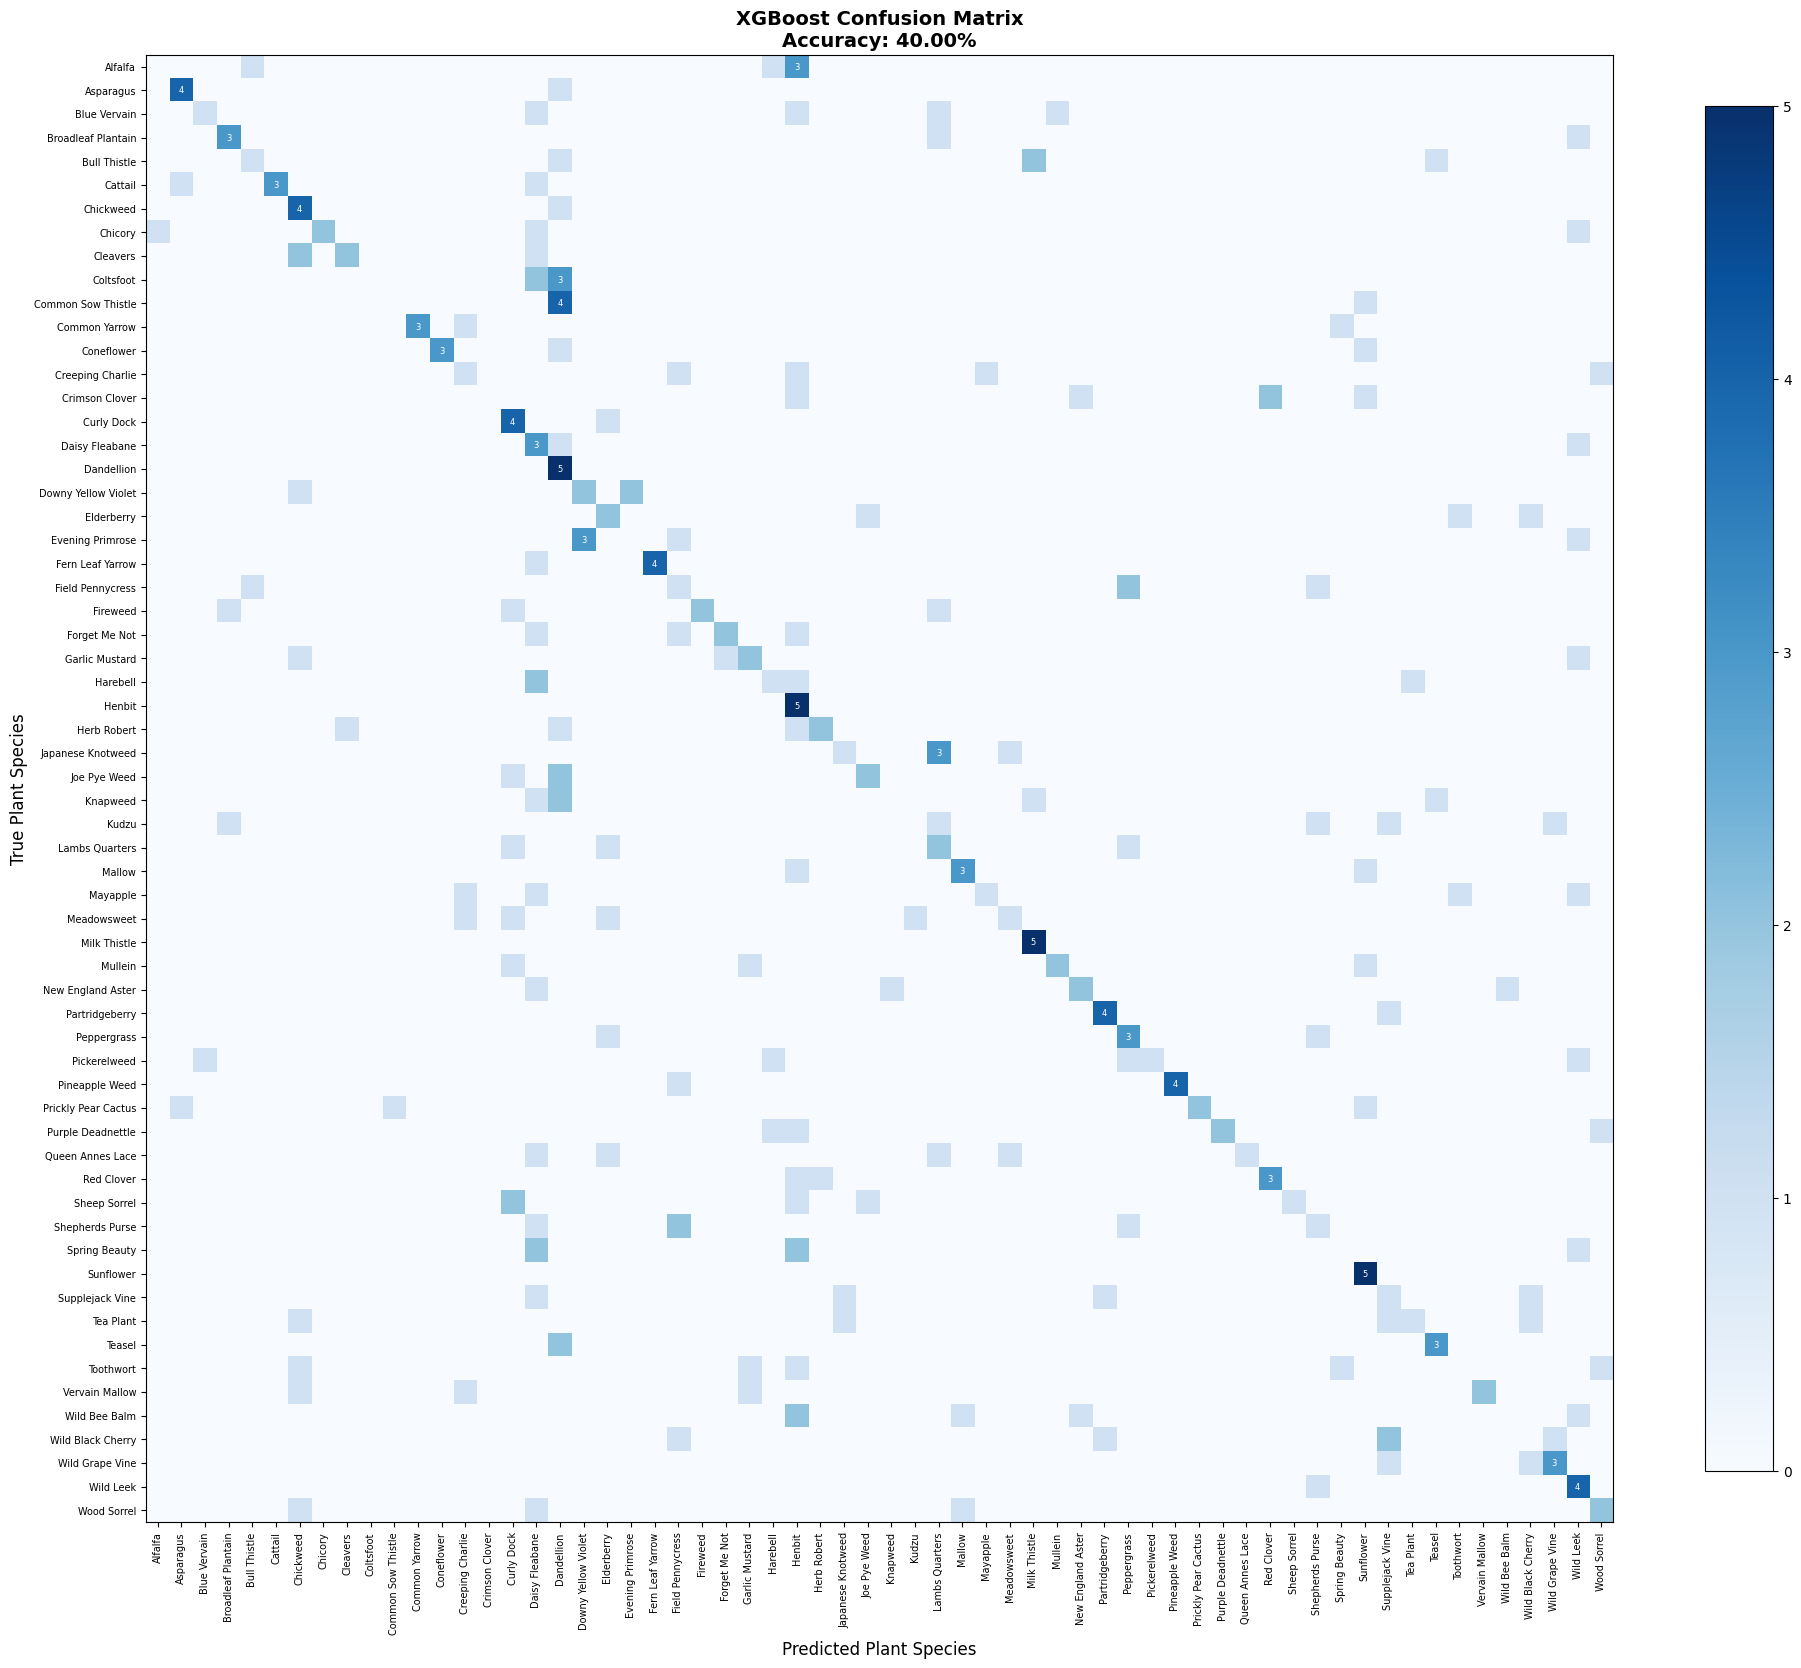


Classification Report:
                     precision    recall  f1-score   support

            Alfalfa       0.00      0.00      0.00         5
          Asparagus       0.67      0.80      0.73         5
       Blue Vervain       0.50      0.20      0.29         5
 Broadleaf Plantain       0.60      0.60      0.60         5
       Bull Thistle       0.33      0.20      0.25         5
            Cattail       1.00      0.60      0.75         5
          Chickweed       0.33      0.80      0.47         5
            Chicory       1.00      0.40      0.57         5
           Cleavers       0.67      0.40      0.50         5
          Coltsfoot       0.00      0.00      0.00         5
 Common Sow Thistle       0.00      0.00      0.00         5
      Common Yarrow       1.00      0.60      0.75         5
         Coneflower       1.00      0.60      0.75         5
   Creeping Charlie       0.20      0.20      0.20         5
     Crimson Clover       0.00      0.00      0.00         5

<Figure size 640x480 with 0 Axes>

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Create confusion matrix
cm = confusion_matrix(Y_test_int, y_pred)

# Calculate accuracy for title
accuracy = np.mean(Y_test_int == y_pred)

# Create the plot
plt.figure(figsize=(20, 18))

# Display matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar(shrink=0.8)

# Add labels - show every class
plt.xticks(range(len(class_names)), class_names, rotation=90, fontsize=7)
plt.yticks(range(len(class_names)), class_names, fontsize=7)

# Add count annotations (optional - might be crowded for 62 classes)
threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Only show large counts to avoid clutter
        if cm[i, j] > threshold:
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > threshold else "black",
                     fontsize=6)

plt.title(f'XGBoost Confusion Matrix\nAccuracy: {accuracy:.2%}', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Plant Species', fontsize=12)
plt.xlabel('Predicted Plant Species', fontsize=12)
plt.tight_layout()
plt.show()

# Print report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(
    Y_test_int,
    y_pred,
    target_names=class_names,
    zero_division=0
))
plt.savefig('xgbconfusmat.png')